<a href="https://colab.research.google.com/github/JonaBaron/TensorFlow/blob/main/06_transfer_learning_tensorflow_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transfer Learning with TensorFlow Part 3: Scaling up (Food Vision mini)

In [1]:
# GPU?
!nvidia-smi

Sat Jan 18 21:32:45 2025       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA L4                      Off | 00000000:00:03.0 Off |                    0 |
| N/A   67C    P8              15W /  72W |      1MiB / 23034MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

## Creating helper functions


In [2]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2025-01-18 21:32:45--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2025-01-18 21:32:45 (20.7 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [3]:
# Import functions
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, compare_historys, walk_through_dir

## Less data


In [4]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
unzip_data("101_food_classes_10_percent.zip")

train_dir = "101_food_classes_10_percent/train/"
test_dir = "101_food_classes_10_percent/test/"

--2025-01-18 21:32:50--  https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.101.207, 142.251.2.207, 142.250.141.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.101.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1625420029 (1.5G) [application/zip]
Saving to: ‘101_food_classes_10_percent.zip’

101_food_classes_10 100%[===================>]   1.51G   204MB/s    in 7.7s    

2025-01-18 21:32:58 (202 MB/s) - ‘101_food_classes_10_percent.zip’ saved [1625420029/1625420029]



In [5]:
# How many images?
walk_through_dir("101_food_classes_10_percent")

There are 2 directories and 0 images in '101_food_classes_10_percent'.
There are 101 directories and 0 images in '101_food_classes_10_percent/test'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/peking_duck'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/bruschetta'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/ice_cream'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/pulled_pork_sandwich'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/croque_madame'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/foie_gras'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/pho'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/bibimbap'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/falafel'.
There are 0 directories and 250 images in '101_foo

In [6]:
# Setup data inputs
import tensorflow as tf
IMG_SIZE = (224, 224)
train_data_all_10_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                                label_mode="categorical",
                                                                                image_size=IMG_SIZE)
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode="categorical",
                                                                image_size=IMG_SIZE,
                                                                shuffle=False) # don't shuffle data

Found 7575 files belonging to 101 classes.
Found 25250 files belonging to 101 classes.


## Train a model with transfer learning on 10% of data


In [7]:
# Create checkpoint callback
checkpoint_path = "101_classes_10_percent_data_model_checkpoint.weights.h5"
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                         save_weights_only=True,
                                                         monitor="val_accuracy",
                                                         save_best_only=True)

In [8]:
# Data augmentation
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

data_augmentation = Sequential([
  layers.RandomFlip("horizontal"),
  layers.RandomRotation(0.2),
  layers.RandomHeight(0.2),
  layers.RandomWidth(0.2),
  layers.RandomZoom(0.2),
  # layers.Rescaling(1/255.)  rescale images ,for models like ResNet50
], name="data_augmentation")

In [9]:
# Setup the base model
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# Setup model
inputs = layers.Input(shape=(224, 224, 3), name="input_layer")
x = data_augmentation(inputs)
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D(name="global_avg_pool_layer")(x)
outputs = layers.Dense(len(train_data_all_10_percent.class_names), activation="softmax", name="output_layer")(x)
model = tf.keras.Model(inputs, outputs)

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [10]:
# Summary
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ data_augmentation (Sequential)       │ (None, None, None, 3)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ efficientnetb0 (Functional)          │ (None, None, None, 1280)    │       4,049,571 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_avg_pool_layer                │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ output_layer (Dense)                 │ (None, 101)                 │         129,381 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,178,952 (15.94 MB)

 Trainable params: 129,381 (505.39 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

In [11]:
# Compile
model.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

# Fit
history_all_classes_10_percent = model.fit(train_data_all_10_percent,
                                           epochs=5,
                                           validation_data=test_data,
                                           validation_steps=int(0.15 * len(test_data)), # 15% of test data
                                           callbacks=[checkpoint_callback])

Epoch 1/5
237/237 ━━━━━━━━━━━━━━━━━━━━ 43s 121ms/step - accuracy: 0.1299 - loss: 4.0692 - val_accuracy: 0.3284 - val_loss: 2.8871
Epoch 2/5
237/237 ━━━━━━━━━━━━━━━━━━━━ 26s 110ms/step - accuracy: 0.4104 - loss: 2.6058 - val_accuracy: 0.4526 - val_loss: 2.2409
Epoch 3/5
237/237 ━━━━━━━━━━━━━━━━━━━━ 25s 107ms/step - accuracy: 0.4817 - loss: 2.1909 - val_accuracy: 0.5220 - val_loss: 1.9126
Epoch 4/5
237/237 ━━━━━━━━━━━━━━━━━━━━ 25s 107ms/step - accuracy: 0.5145 - loss: 1.9681 - val_accuracy: 0.5514 - val_loss: 1.8128
Epoch 5/5
237/237 ━━━━━━━━━━━━━━━━━━━━ 24s 103ms/step - accuracy: 0.5458 - loss: 1.8257 - val_accuracy: 0.6075 - val_loss: 1.5764


In [12]:
# Evaluate
feature_extraction_results = model.evaluate(test_data)
feature_extraction_results

790/790 ━━━━━━━━━━━━━━━━━━━━ 32s 40ms/step - accuracy: 0.4964 - loss: 1.9492


[1.8241206407546997, 0.5287920832633972]

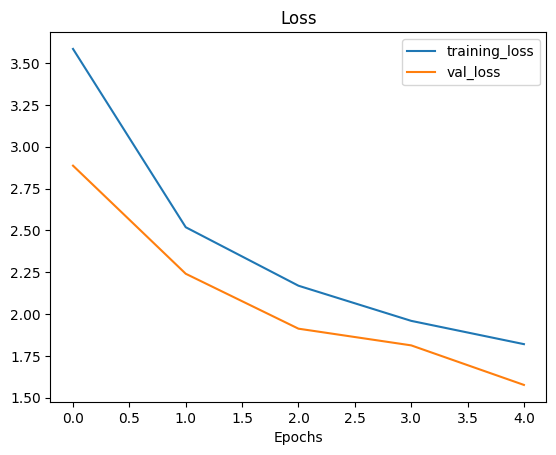

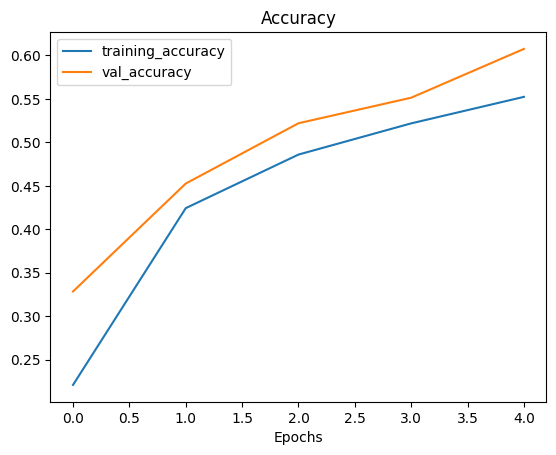

In [13]:
# Plot loss curves
plot_loss_curves(history_all_classes_10_percent)

Looks like our model is overfiting, bc the lines should be very similar

## Fine-tuning

In [14]:
# Unfreeze all of the layers in model
base_model.trainable = True

# freeze every layer except the last 5
for layer in base_model.layers[:-5]:
  layer.trainable = False

In [15]:
# compile model with lower learning
model.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              metrics=["accuracy"])

In [16]:
# What layers are trainable?
for layer in model.layers:
  print(layer.name, layer.trainable)

input_layer True
data_augmentation True
efficientnetb0 True
global_avg_pool_layer True
output_layer True


In [17]:
# To look deeper
for layer_number, layer in enumerate(model.layers[2].layers):
  print(layer_number, layer.name, layer.trainable)

0 input_layer False
1 rescaling False
2 normalization False
3 rescaling_1 False
4 stem_conv_pad False
5 stem_conv False
6 stem_bn False
7 stem_activation False
8 block1a_dwconv False
9 block1a_bn False
10 block1a_activation False
11 block1a_se_squeeze False
12 block1a_se_reshape False
13 block1a_se_reduce False
14 block1a_se_expand False
15 block1a_se_excite False
16 block1a_project_conv False
17 block1a_project_bn False
18 block2a_expand_conv False
19 block2a_expand_bn False
20 block2a_expand_activation False
21 block2a_dwconv_pad False
22 block2a_dwconv False
23 block2a_bn False
24 block2a_activation False
25 block2a_se_squeeze False
26 block2a_se_reshape False
27 block2a_se_reduce False
28 block2a_se_expand False
29 block2a_se_excite False
30 block2a_project_conv False
31 block2a_project_bn False
32 block2b_expand_conv False
33 block2b_expand_bn False
34 block2b_expand_activation False
35 block2b_dwconv False
36 block2b_bn False
37 block2b_activation False
38 block2b_se_squeeze Fals

In [18]:
# 5 more epochs (5 + 5 = 10)
fine_tune_epochs = 10

# Fit (Fine-tune)
history_all_classes_10_percent_fine_tune = model.fit(train_data_all_10_percent,
                                                     epochs=fine_tune_epochs,
                                                     validation_data=test_data,
                                                     validation_steps=int(0.15 * len(test_data)),
                                                     initial_epoch=history_all_classes_10_percent.epoch[-1])

Epoch 5/10
237/237 ━━━━━━━━━━━━━━━━━━━━ 38s 114ms/step - accuracy: 0.5657 - loss: 1.7849 - val_accuracy: 0.4831 - val_loss: 2.0075
Epoch 6/10
237/237 ━━━━━━━━━━━━━━━━━━━━ 25s 104ms/step - accuracy: 0.6055 - loss: 1.5938 - val_accuracy: 0.5246 - val_loss: 1.8127
Epoch 7/10
237/237 ━━━━━━━━━━━━━━━━━━━━ 24s 100ms/step - accuracy: 0.6282 - loss: 1.5024 - val_accuracy: 0.5993 - val_loss: 1.5589
Epoch 8/10
237/237 ━━━━━━━━━━━━━━━━━━━━ 24s 100ms/step - accuracy: 0.6436 - loss: 1.4236 - val_accuracy: 0.5789 - val_loss: 1.6168
Epoch 9/10
237/237 ━━━━━━━━━━━━━━━━━━━━ 24s 100ms/step - accuracy: 0.6572 - loss: 1.3469 - val_accuracy: 0.6200 - val_loss: 1.4374
Epoch 10/10
237/237 ━━━━━━━━━━━━━━━━━━━━ 24s 99ms/step - accuracy: 0.6749 - loss: 1.3041 - val_accuracy: 0.6075 - val_loss: 1.4507


In [19]:
# Evaluate
all_classes_10_percent_fine_tune_results = model.evaluate(test_data)
all_classes_10_percent_fine_tune_results

790/790 ━━━━━━━━━━━━━━━━━━━━ 32s 40ms/step - accuracy: 0.5492 - loss: 1.7232


[1.6171568632125854, 0.5725148320198059]

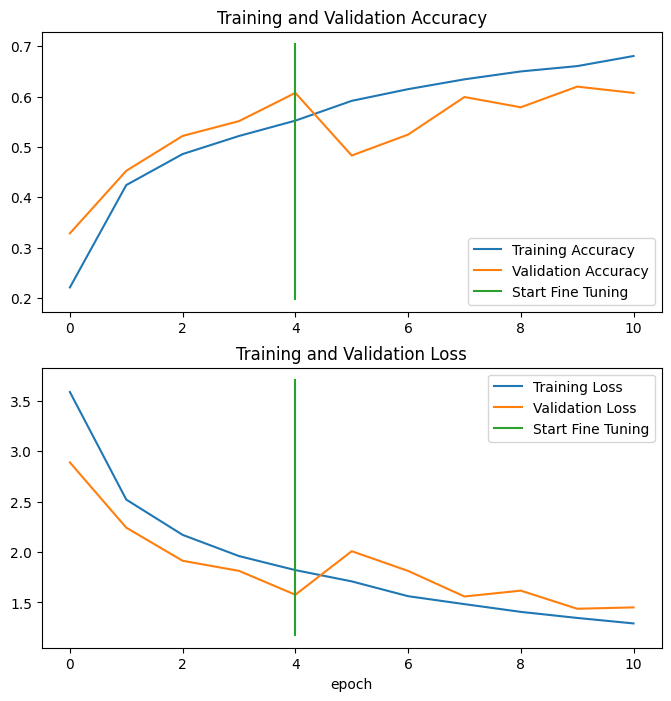

In [20]:
# Compare histories
compare_historys(original_history=history_all_classes_10_percent,
                 new_history=history_all_classes_10_percent_fine_tune,
                 initial_epochs=5)

## Save and load


In [23]:
# Save our model
model.save("drive/MyDrive/tensorflow_course/101_food_classes_10_percent_saved_big_dog_model.keras")

In [24]:
# Load model
loaded_model = tf.keras.models.load_model("drive/MyDrive/tensorflow_course/101_food_classes_10_percent_saved_big_dog_model.keras")

In [25]:
# Evaluate
loaded_model_results = loaded_model.evaluate(test_data)
loaded_model_results

790/790 ━━━━━━━━━━━━━━━━━━━━ 36s 41ms/step - accuracy: 0.5285 - loss: 1.8162


[1.6868479251861572, 0.5556039810180664]

In [26]:
all_classes_10_percent_fine_tune_results

[1.6171568632125854, 0.5725148320198059]

## Evaluating the performance of the model


In [27]:
import tensorflow as tf

# Download pretrained model
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/06_101_food_class_10_percent_saved_big_dog_model.zip

--2025-01-18 21:42:20--  https://storage.googleapis.com/ztm_tf_course/food_vision/06_101_food_class_10_percent_saved_big_dog_model.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.101.207, 142.251.2.207, 142.250.141.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.101.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 46760742 (45M) [application/zip]
Saving to: ‘06_101_food_class_10_percent_saved_big_dog_model.zip’

06_101_food_class_1 100%[===================>]  44.59M   117MB/s    in 0.4s    

2025-01-18 21:42:21 (117 MB/s) - ‘06_101_food_class_10_percent_saved_big_dog_model.zip’ saved [46760742/46760742]



In [28]:
unzip_data("/content/06_101_food_class_10_percent_saved_big_dog_model.zip")

In [29]:
import tf_keras as k3

model = k3.models.load_model("/content/06_101_food_class_10_percent_saved_big_dog_model")



In [30]:
loaded_loss, loaded_accuracy = model.evaluate(test_data)
loaded_loss, loaded_accuracy

790/790 [==============================] - 30s 35ms/step - loss: 1.8019 - accuracy: 0.6077


(1.8019264936447144, 0.6077227592468262)

In [31]:
results_downloaded_model = loaded_loss, loaded_accuracy

## Making predictions

In [32]:
# Make predictions
preds_probs = model.predict(test_data)

790/790 [==============================] - 27s 33ms/step


In [33]:
len(test_data)

790

In [34]:
# How many predictions?
len(preds_probs)

25250

In [35]:
preds_probs.shape

(25250, 101)

In [36]:
# Let's seethe first 10 predictions
preds_probs[:10]

array([[5.9642594e-02, 3.6032050e-06, 4.1484680e-02, ..., 1.4250841e-09,
        8.4996274e-05, 3.1029359e-03],
       [9.6314037e-01, 1.3880245e-09, 8.5903954e-04, ..., 5.4147458e-05,
        7.8175175e-12, 9.8949526e-10],
       [9.5920092e-01, 3.2449665e-05, 1.4923296e-03, ..., 7.1437995e-07,
        5.4827865e-07, 4.0047682e-05],
       ...,
       [4.7457245e-01, 1.2968803e-07, 1.4742543e-03, ..., 5.9015770e-04,
        6.7275469e-05, 2.3489229e-05],
       [4.4969093e-02, 4.6990723e-07, 1.2290883e-01, ..., 6.2334489e-06,
        7.5558501e-06, 3.6882018e-03],
       [7.2507560e-01, 1.9155688e-09, 5.2278552e-05, ..., 1.2186896e-03,
        1.5681902e-09, 9.6289776e-05]], dtype=float32)

In [37]:
preds_probs[0], len(preds_probs[0]), sum(preds_probs[0])

(array([5.9642594e-02, 3.6032050e-06, 4.1484680e-02, 1.0735270e-09,
        8.3584091e-09, 8.6690353e-09, 8.0283746e-07, 8.5666915e-07,
        2.0040488e-05, 8.0207678e-07, 3.1758243e-09, 9.8560452e-07,
        2.8360070e-04, 7.7958845e-10, 7.4835116e-04, 3.9327133e-05,
        6.5010086e-06, 2.5085189e-06, 3.7826449e-05, 2.0486972e-07,
        1.5694595e-05, 8.0714887e-07, 2.6100197e-06, 2.0148819e-07,
        8.3171017e-07, 5.4978477e-06, 3.7803709e-06, 1.3214138e-08,
        2.7581900e-03, 2.8175447e-05, 6.9486972e-10, 2.5290101e-05,
        1.6750819e-04, 7.6689033e-10, 4.0753241e-04, 1.3160136e-08,
        1.8008731e-06, 1.4565012e-06, 2.3148993e-02, 8.2974060e-07,
        8.6433869e-07, 1.6919122e-06, 7.0765514e-06, 1.8643206e-08,
        2.8890105e-07, 8.0857762e-06, 2.0891691e-06, 1.8753022e-07,
        3.3793917e-08, 3.1756732e-04, 1.0518541e-05, 8.6779113e-07,
        8.4703845e-01, 1.0593943e-05, 4.3484482e-07, 3.7516907e-05,
        3.5475874e-05, 3.3068289e-05, 6.7305082e

In [38]:
print(f"Number of prediction probabilities for sample 0: {len(preds_probs[0])}")
print(f"What prediction probability sample 0 looks like:\n {preds_probs[0]}")
print(f"The class with the highest predicted probability by the model for sample 0: {preds_probs[0].argmax()}")

Number of prediction probabilities for sample 0: 101
What prediction probability sample 0 looks like:
 [5.9642594e-02 3.6032050e-06 4.1484680e-02 1.0735270e-09 8.3584091e-09
 8.6690353e-09 8.0283746e-07 8.5666915e-07 2.0040488e-05 8.0207678e-07
 3.1758243e-09 9.8560452e-07 2.8360070e-04 7.7958845e-10 7.4835116e-04
 3.9327133e-05 6.5010086e-06 2.5085189e-06 3.7826449e-05 2.0486972e-07
 1.5694595e-05 8.0714887e-07 2.6100197e-06 2.0148819e-07 8.3171017e-07
 5.4978477e-06 3.7803709e-06 1.3214138e-08 2.7581900e-03 2.8175447e-05
 6.9486972e-10 2.5290101e-05 1.6750819e-04 7.6689033e-10 4.0753241e-04
 1.3160136e-08 1.8008731e-06 1.4565012e-06 2.3148993e-02 8.2974060e-07
 8.6433869e-07 1.6919122e-06 7.0765514e-06 1.8643206e-08 2.8890105e-07
 8.0857762e-06 2.0891691e-06 1.8753022e-07 3.3793917e-08 3.1756732e-04
 1.0518541e-05 8.6779113e-07 8.4703845e-01 1.0593943e-05 4.3484482e-07
 3.7516907e-05 3.5475874e-05 3.3068289e-05 6.7305082e-05 1.2790908e-08
 2.6363414e-10 1.0388107e-05 8.6128690e-05 1.

In [39]:
# Get the pred classes
pred_classes = preds_probs.argmax(axis=1)

pred_classes[:10]

array([52,  0,  0, 80, 79, 61, 29,  0, 85,  0])

In [40]:
len(pred_classes)

25250

In [41]:
# To get our test labels we need to unravel our test_data BatchDataset
y_labels = []
for images, labels in test_data.unbatch():
  y_labels.append(labels.numpy().argmax()) # test labels look: [0, 0, 0, 1, .... 0, 0]
y_labels[:10] # look at the first 10

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [42]:
len(y_labels)

25250

In [43]:
test_data

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 101), dtype=tf.float32, name=None))>

In [44]:
len(test_data)

790

## Evaluating our model prediction

In [45]:
results_downloaded_model

(1.8019264936447144, 0.6077227592468262)

In [46]:
# Scikit-learn's accuracy score function
from sklearn.metrics import accuracy_score
sklearn_accuracy = accuracy_score(y_true=y_labels,
                                  y_pred=pred_classes)
sklearn_accuracy

0.6077227722772277

In [47]:
import numpy as np
np.isclose(results_downloaded_model[1], sklearn_accuracy)

True

## Confusion matrix

In [48]:
from helper_functions import make_confusion_matrix

In [49]:
# Get a list of class
class_names = test_data.class_names
class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

In [50]:
# Copy from Github

import itertools
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

# We need to make some changes to our make_confusion_matrix function to ensure the x-labels print vertically
def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(10, 10), text_size=15, norm=False, savefig=False):
  """Makes a labelled confusion matrix comparing predictions and ground truth labels.

  If classes is passed, confusion matrix will be labelled, if not, integer class values
  will be used.

  Args:
    y_true: Array of truth labels (must be same shape as y_pred).
    y_pred: Array of predicted labels (must be same shape as y_true).
    classes: Array of class labels (e.g. string form). If `None`, integer labels are used.
    figsize: Size of output figure (default=(10, 10)).
    text_size: Size of output figure text (default=15).
    norm: normalize values or not (default=False).
    savefig: save confusion matrix to file (default=False).

  Returns:
    A labelled confusion matrix plot comparing y_true and y_pred.

  Example usage:
    make_confusion_matrix(y_true=test_labels, # ground truth test labels
                          y_pred=y_preds, # predicted labels
                          classes=class_names, # array of class label names
                          figsize=(15, 15),
                          text_size=10)
  """
  # Create the confustion matrix
  cm = confusion_matrix(y_true, y_pred)
  cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it
  n_classes = cm.shape[0] # find the number of classes we're dealing with

  # Plot the figure and make it pretty
  fig, ax = plt.subplots(figsize=figsize)
  cax = ax.matshow(cm, cmap=plt.cm.Blues) # colors will represent how 'correct' a class is, darker == better
  fig.colorbar(cax)

  # Are there a list of classes?
  if classes:
    labels = classes
  else:
    labels = np.arange(cm.shape[0])

  # Label the axes
  ax.set(title="Confusion Matrix",
         xlabel="Predicted label",
         ylabel="True label",
         xticks=np.arange(n_classes), # create enough axis slots for each class
         yticks=np.arange(n_classes),
         xticklabels=labels, # axes will labeled with class names (if they exist) or ints
         yticklabels=labels)

  # Make x-axis labels appear on bottom
  ax.xaxis.set_label_position("bottom")
  ax.xaxis.tick_bottom()

  ### Changed (plot x-labels vertically) ###
  plt.xticks(rotation=70, fontsize=text_size)
  plt.yticks(fontsize=text_size)

  # Set the threshold for different colors
  threshold = (cm.max() + cm.min()) / 2.

  # Plot the text on each cell
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    if norm:
      plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)
    else:
      plt.text(j, i, f"{cm[i, j]}",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)

  # Save the figure to the current working directory
  if savefig:
    fig.savefig("confusion_matrix.png")

In [51]:
make_confusion_matrix(y_true=y_labels,
                      y_pred=pred_classes,
                      classes=class_names,
                      figsize=(100, 100),
                      text_size=20,
                      savefig=True)

## Classification report


In [52]:
from sklearn.metrics import classification_report
print(classification_report(y_true=y_labels,
                            y_pred=pred_classes))

              precision    recall  f1-score   support

           0       0.29      0.20      0.24       250
           1       0.51      0.69      0.59       250
           2       0.56      0.65      0.60       250
           3       0.74      0.52      0.61       250
           4       0.74      0.44      0.55       250
           5       0.35      0.54      0.42       250
           6       0.67      0.79      0.72       250
           7       0.82      0.76      0.79       250
           8       0.40      0.37      0.39       250
           9       0.62      0.44      0.51       250
          10       0.62      0.42      0.50       250
          11       0.83      0.48      0.61       250
          12       0.52      0.74      0.61       250
          13       0.56      0.60      0.58       250
          14       0.56      0.59      0.57       250
          15       0.44      0.32      0.37       250
          16       0.45      0.75      0.57       250
          17       0.37    

In [53]:
# Dictionary of the classification report
classification_report_dict = classification_report(y_labels, pred_classes, output_dict=True)
classification_report_dict

{'0': {'precision': 0.29310344827586204,
  'recall': 0.204,
  'f1-score': 0.24056603773584906,
  'support': 250.0},
 '1': {'precision': 0.5088235294117647,
  'recall': 0.692,
  'f1-score': 0.5864406779661017,
  'support': 250.0},
 '2': {'precision': 0.5605536332179931,
  'recall': 0.648,
  'f1-score': 0.601113172541744,
  'support': 250.0},
 '3': {'precision': 0.7401129943502824,
  'recall': 0.524,
  'f1-score': 0.6135831381733021,
  'support': 250.0},
 '4': {'precision': 0.7364864864864865,
  'recall': 0.436,
  'f1-score': 0.5477386934673367,
  'support': 250.0},
 '5': {'precision': 0.3452685421994885,
  'recall': 0.54,
  'f1-score': 0.42121684867394693,
  'support': 250.0},
 '6': {'precision': 0.6700680272108843,
  'recall': 0.788,
  'f1-score': 0.7242647058823529,
  'support': 250.0},
 '7': {'precision': 0.8197424892703863,
  'recall': 0.764,
  'f1-score': 0.7908902691511387,
  'support': 250.0},
 '8': {'precision': 0.4025974025974026,
  'recall': 0.372,
  'f1-score': 0.386694386694

In [54]:
# Plot our F1-scores
class_names[98]

'tiramisu'

In [55]:
classification_report_dict["99"]["f1-score"]

0.3526315789473684

In [56]:
# Empty dictionary
class_f1_scores = {}
# Loop in classification report dictionary items
for k, v in classification_report_dict.items():
  if k == "accuracy": # stop once we get to accuracy key
    break
  else:
    # Add class names and f1-scores to new dictionary
    class_f1_scores[class_names[int(k)]] = v["f1-score"]
class_f1_scores

{'apple_pie': 0.24056603773584906,
 'baby_back_ribs': 0.5864406779661017,
 'baklava': 0.601113172541744,
 'beef_carpaccio': 0.6135831381733021,
 'beef_tartare': 0.5477386934673367,
 'beet_salad': 0.42121684867394693,
 'beignets': 0.7242647058823529,
 'bibimbap': 0.7908902691511387,
 'bread_pudding': 0.3866943866943867,
 'breakfast_burrito': 0.5117370892018779,
 'bruschetta': 0.5047619047619047,
 'caesar_salad': 0.6126582278481013,
 'cannoli': 0.6115702479338843,
 'caprese_salad': 0.5775193798449613,
 'carrot_cake': 0.574757281553398,
 'ceviche': 0.37122969837587005,
 'cheese_plate': 0.5654135338345865,
 'cheesecake': 0.426890756302521,
 'chicken_curry': 0.5,
 'chicken_quesadilla': 0.6411889596602972,
 'chicken_wings': 0.7074569789674953,
 'chocolate_cake': 0.4526166902404526,
 'chocolate_mousse': 0.325,
 'churros': 0.7134935304990758,
 'clam_chowder': 0.7708779443254818,
 'club_sandwich': 0.7325102880658436,
 'crab_cakes': 0.46153846153846156,
 'creme_brulee': 0.7494824016563147,
 'cro

In [57]:
# F1-scores into dataframe
import pandas as pd
f1_scores = pd.DataFrame({"class_names": list(class_f1_scores.keys()),
                          "f1-score": list(class_f1_scores.values())}).sort_values("f1-score", ascending=False)

In [58]:
f1_scores[:10]

class_names  f1-score
33              edamame  0.937143
63             macarons  0.895397
75                  pho  0.868217
91  spaghetti_carbonara  0.847656
69              oysters  0.834008
68          onion_rings  0.832618
65              mussels  0.820000
88        seaweed_salad  0.814664
64            miso_soup  0.812977
54    hot_and_sour_soup  0.810345

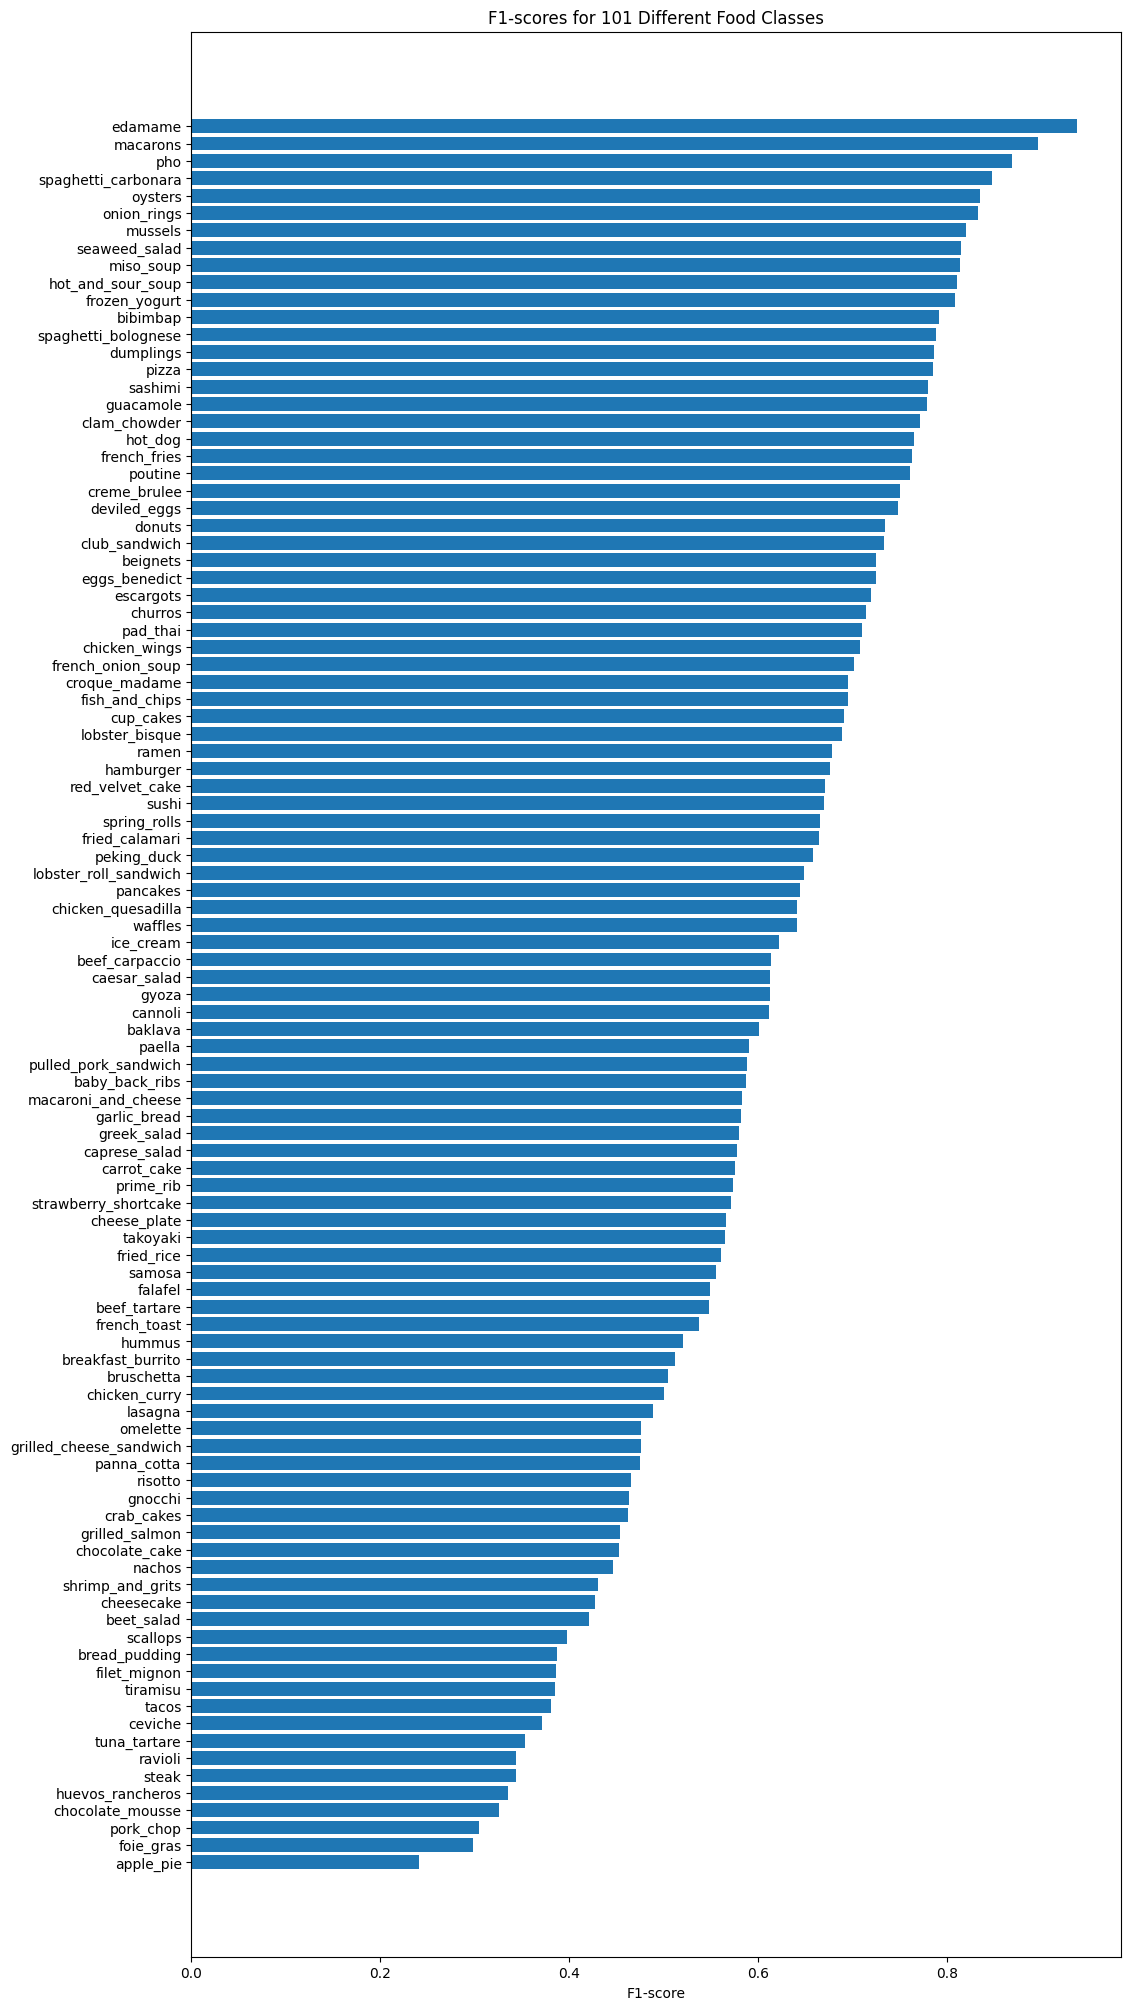

In [59]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12, 25))
scores = ax.barh(range(len(f1_scores)), f1_scores["f1-score"].values)
ax.set_yticks(range(len(f1_scores)))
ax.set_yticklabels(f1_scores["class_names"])
ax.set_xlabel("F1-score")
ax.set_title("F1-scores for 101 Different Food Classes")
ax.invert_yaxis();

## Visualizing predictions on test images


In [60]:
# Copy from Github

# Create a function to load and prepare images
def load_and_prep_image(filename, img_shape=224, scale=True):
  """
  Reads in an image from filename, turns it into a tensor and reshapes into
  specified shape (img_shape, img_shape, color_channels=3).

  Args:
    filename (str): path to target image
    image_shape (int): height/width dimension of target image size
    scale (bool): scale pixel values from 0-255 to 0-1 or not

  Returns:
    Image tensor of shape (img_shape, img_shape, 3)
  """
  # Read in the image
  img = tf.io.read_file(filename)

  # Decode image into tensor
  img = tf.io.decode_image(img, channels=3)

  # Resize the image
  img = tf.image.resize(img, [img_shape, img_shape])

  # Scale? Yes/no
  if scale:
    # rescale the image (get all values between 0 and 1)
    return img/255.
  else:
    return img # don't need to rescale images for EfficientNet models in TensorFlow

In [61]:
train_data_all_10_percent

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 101), dtype=tf.float32, name=None))>

1/1 [==============================] - 2s 2s/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 27ms/step


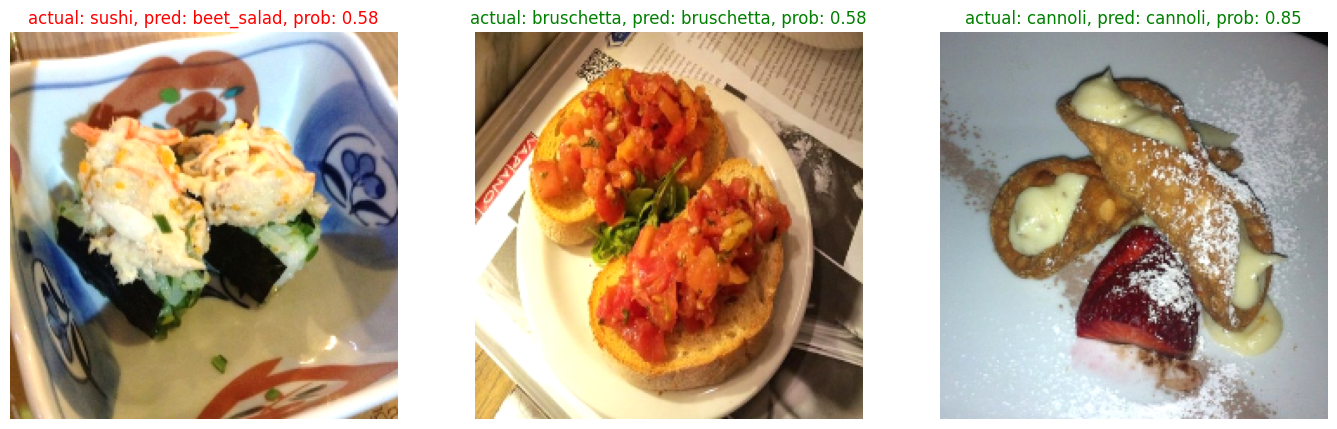

In [62]:
# Make preds on  random images
import os
import random

plt.figure(figsize=(17, 10))
for i in range(3):
  class_name = random.choice(class_names)
  filename = random.choice(os.listdir(test_dir + "/" + class_name))
  filepath = test_dir + class_name + "/" + filename

  # Load and make predictions
  img = load_and_prep_image(filepath, scale=False)
  img_expanded = tf.expand_dims(img, axis=0)
  pred_prob = model.predict(img_expanded)
  pred_class = class_names[pred_prob.argmax()]


  plt.subplot(1, 3, i+1)
  plt.imshow(img/225.)
   # if  matches truth class, the text is green
  if class_name == pred_class:
    title_color = "g"
  else:
    title_color = "r"
  plt.title(f"actual: {class_name}, pred: {pred_class}, prob: {pred_prob.max():.2f}", c=title_color)
  plt.axis(False);

## Finding the most wrong predictions


In [63]:
#Get all of the paths in the test dataset
filepaths = []
for filepath in test_data.list_files("/content/101_food_classes_10_percent/test/*/*.jpg",
                                     shuffle=False):
  filepaths.append(filepath.numpy())
filepaths[:10]

[b'/content/101_food_classes_10_percent/test/apple_pie/1011328.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/101251.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/1034399.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/103801.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/1038694.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/1047447.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/1068632.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/110043.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/1106961.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/1113017.jpg']

In [64]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [65]:
# Create a DataFrame
import pandas as pd
pred_df = pd.DataFrame({"img_path": filepaths,
                        "y_true": y_labels,
                        "y_pred": pred_classes,
                        "pred_conf": preds_probs.max(axis=1), # get the maximum prediction probability value
                        "y_true_classname": [class_names[i] for i in y_labels],
                        "y_pred_classname": [class_names[i] for i in pred_classes]})
pred_df

img_path  y_true  y_pred  \
0      b'/content/101_food_classes_10_percent/test/ap...       0      52   
1      b'/content/101_food_classes_10_percent/test/ap...       0       0   
2      b'/content/101_food_classes_10_percent/test/ap...       0       0   
3      b'/content/101_food_classes_10_percent/test/ap...       0      80   
4      b'/content/101_food_classes_10_percent/test/ap...       0      79   
...                                                  ...     ...     ...   
25245  b'/content/101_food_classes_10_percent/test/wa...     100     100   
25246  b'/content/101_food_classes_10_percent/test/wa...     100      16   
25247  b'/content/101_food_classes_10_percent/test/wa...     100     100   
25248  b'/content/101_food_classes_10_percent/test/wa...     100      94   
25249  b'/content/101_food_classes_10_percent/test/wa...     100     100   

       pred_conf y_true_classname      y_pred_classname  
0       0.847038        apple_pie                 gyoza  
1       0.963140        apple_pie             apple_pie  
2       0.959201        apple_pie             apple_pie  
3       0.655443        apple_pie  pulled_pork_sandwich  
4       0.359701        apple_pie             prime_rib  
...          ...              ...                   ...  
25245   0.972788          waffles               waffles  
25246   0.880401          waffles          cheese_plate  
25247   0.540589          waffles               waffles  
25248   0.506653          waffles  strawberry_shortcake  
25249   0.689265          waffles               waffles  

[25250 rows x 6 columns]

In [66]:
# 3. Find which predictions are wrong
pred_df["pred_correct"] = pred_df["y_true"] == pred_df["y_pred"]
pred_df.head()

img_path  y_true  y_pred  \
0  b'/content/101_food_classes_10_percent/test/ap...       0      52   
1  b'/content/101_food_classes_10_percent/test/ap...       0       0   
2  b'/content/101_food_classes_10_percent/test/ap...       0       0   
3  b'/content/101_food_classes_10_percent/test/ap...       0      80   
4  b'/content/101_food_classes_10_percent/test/ap...       0      79   

   pred_conf y_true_classname      y_pred_classname  pred_correct  
0   0.847038        apple_pie                 gyoza         False  
1   0.963140        apple_pie             apple_pie          True  
2   0.959201        apple_pie             apple_pie          True  
3   0.655443        apple_pie  pulled_pork_sandwich         False  
4   0.359701        apple_pie             prime_rib         False

In [67]:
# Sort to have most wrong predictions at the top
top_100_wrong = pred_df[pred_df["pred_correct"] == False].sort_values("pred_conf", ascending=False)[:100]
top_100_wrong.head(20)

img_path  y_true  y_pred  \
21810  b'/content/101_food_classes_10_percent/test/sc...      87      29   
231    b'/content/101_food_classes_10_percent/test/ap...       0     100   
15359  b'/content/101_food_classes_10_percent/test/lo...      61      53   
23539  b'/content/101_food_classes_10_percent/test/st...      94      83   
21400  b'/content/101_food_classes_10_percent/test/sa...      85      92   
24540  b'/content/101_food_classes_10_percent/test/ti...      98      83   
2511   b'/content/101_food_classes_10_percent/test/br...      10      61   
5574   b'/content/101_food_classes_10_percent/test/ch...      22      21   
17855  b'/content/101_food_classes_10_percent/test/pa...      71      65   
23797  b'/content/101_food_classes_10_percent/test/su...      95      86   
18001  b'/content/101_food_classes_10_percent/test/pa...      72      67   
11642  b'/content/101_food_classes_10_percent/test/ga...      46      10   
10847  b'/content/101_food_classes_10_percent/test/fr...      43      68   
23631  b'/content/101_food_classes_10_percent/test/st...      94      83   
10854  b'/content/101_food_classes_10_percent/test/fr...      43      68   
1155   b'/content/101_food_classes_10_percent/test/be...       4       5   
23904  b'/content/101_food_classes_10_percent/test/su...      95      86   
7316   b'/content/101_food_classes_10_percent/test/cu...      29      83   
13144  b'/content/101_food_classes_10_percent/test/gy...      52      92   
10880  b'/content/101_food_classes_10_percent/test/fr...      43      68   

       pred_conf       y_true_classname       y_pred_classname  pred_correct  
21810   0.999997               scallops              cup_cakes         False  
231     0.999995              apple_pie                waffles         False  
15359   0.999988  lobster_roll_sandwich              hamburger         False  
23539   0.999987   strawberry_shortcake        red_velvet_cake         False  
21400   0.999982                 samosa           spring_rolls         False  
24540   0.999946               tiramisu        red_velvet_cake         False  
2511    0.999945             bruschetta  lobster_roll_sandwich         False  
5574    0.999939       chocolate_mousse         chocolate_cake         False  
17855   0.999931                 paella                mussels         False  
23797   0.999905                  sushi                sashimi         False  
18001   0.999902               pancakes               omelette         False  
11642   0.999878           garlic_bread             bruschetta         False  
10847   0.999870         fried_calamari            onion_rings         False  
23631   0.999858   strawberry_shortcake        red_velvet_cake         False  
10854   0.999856         fried_calamari            onion_rings         False  
1155    0.999856           beef_tartare             beet_salad         False  
23904   0.999821                  sushi                sashimi         False  
7316    0.999817              cup_cakes        red_velvet_cake         False  
13144   0.999799                  gyoza           spring_rolls         False  
10880   0.999781         fried_calamari            onion_rings         False

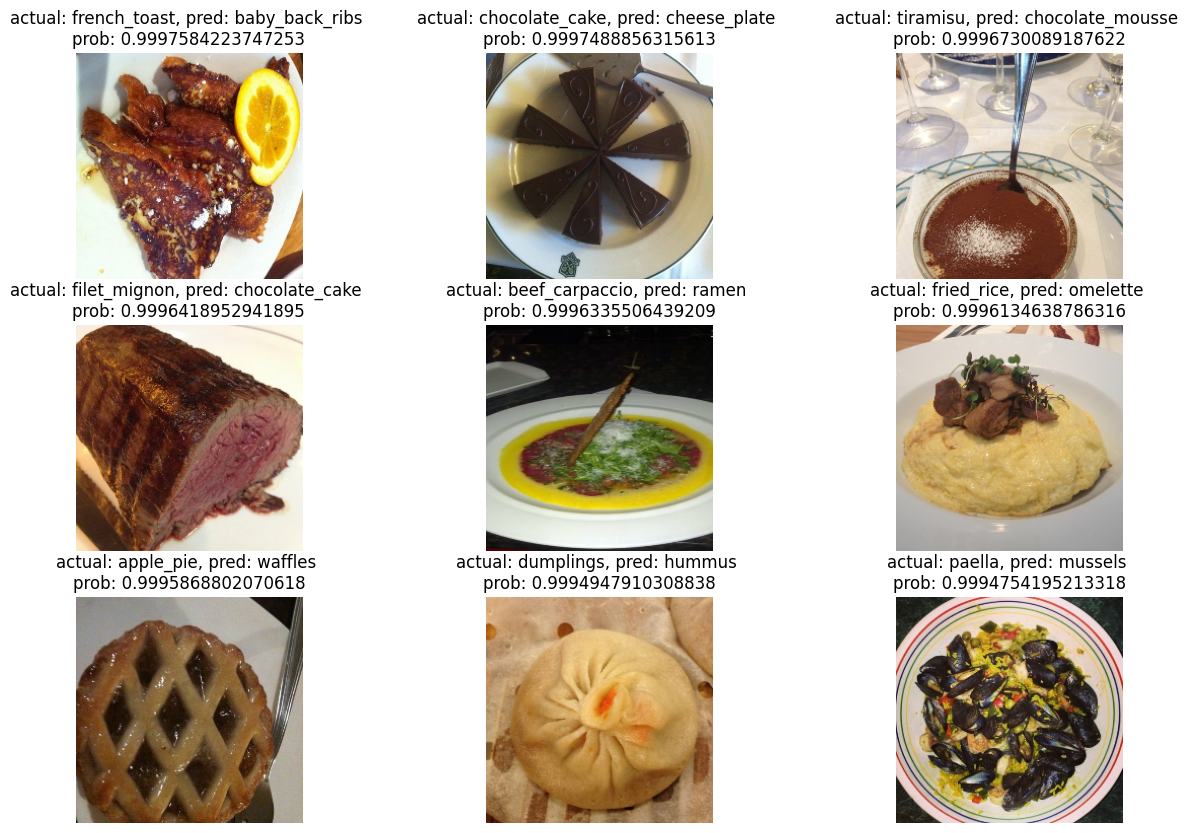

In [68]:
# 5. Visualize the test data samples which have the wrong prediction but highest pred probability
images_to_view = 9
start_index = 20
plt.figure(figsize=(15, 10))
for i, row in enumerate(top_100_wrong[start_index:start_index+images_to_view].itertuples()):
  plt.subplot(3, 3, i+1)
  img = load_and_prep_image(row[1], scale=False)
  _, _, _, _, pred_prob, y_true_classname, y_pred_classname, _ = row # only interested in a few parameters of each row
  plt.imshow(img/255.)
  plt.title(f"actual: {y_true_classname}, pred: {y_pred_classname} \nprob: {pred_prob}")
  plt.axis(False)

## Test the model on custom images

In [69]:
# Get custom images
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/custom_food_images.zip

unzip_data("custom_food_images.zip")

--2025-01-18 21:44:32--  https://storage.googleapis.com/ztm_tf_course/food_vision/custom_food_images.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.101.207, 142.251.2.207, 142.250.141.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.101.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13192985 (13M) [application/zip]
Saving to: ‘custom_food_images.zip’

custom_food_images. 100%[===================>]  12.58M  --.-KB/s    in 0.1s    

2025-01-18 21:44:33 (108 MB/s) - ‘custom_food_images.zip’ saved [13192985/13192985]



In [70]:
# Get the filepaths
custom_food_images = ["custom_food_images/" + img_path for img_path in os.listdir("custom_food_images")]
custom_food_images

['custom_food_images/steak.jpeg',
 'custom_food_images/ramen.jpeg',
 'custom_food_images/chicken_wings.jpeg',
 'custom_food_images/hamburger.jpeg',
 'custom_food_images/pizza-dad.jpeg',
 'custom_food_images/sushi.jpeg']

1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 29ms/step


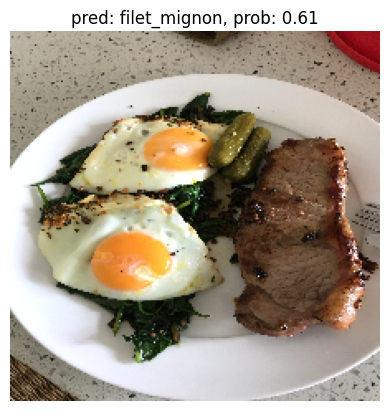

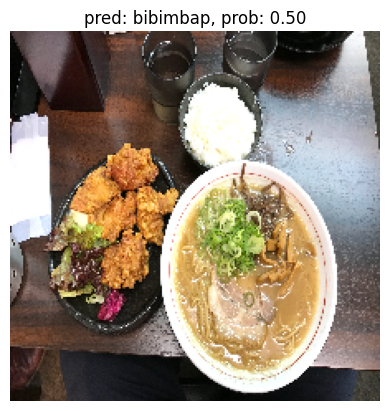

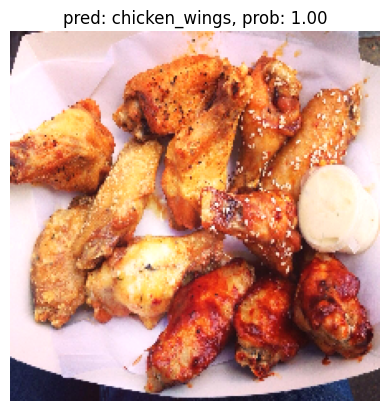

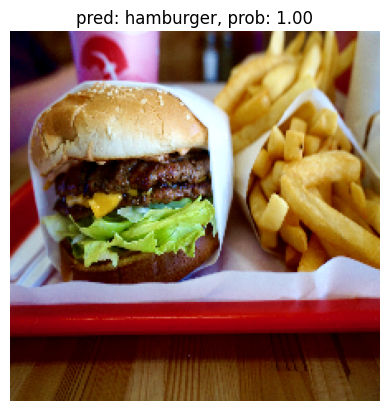

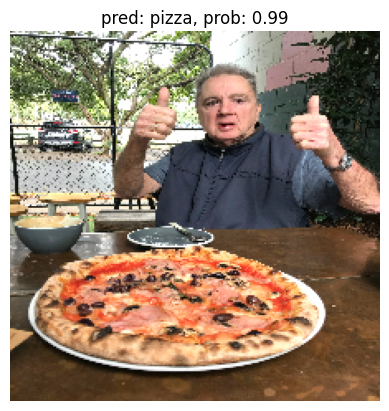

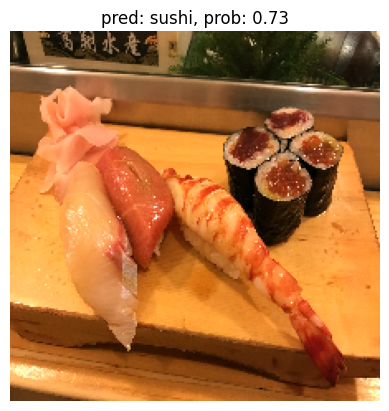

In [71]:
# Make predictions and plot images
for img in custom_food_images:
  img = load_and_prep_image(img, scale=False)
  pred_prob = model.predict(tf.expand_dims(img, axis=0))
  pred_class = class_names[pred_prob.argmax()]
  # Plot
  plt.figure()
  plt.imshow(img/225.)
  plt.title(f"pred: {pred_class}, prob: {pred_prob.max():.2f}")
  plt.axis(False)